# Статистический анализ изображений

### Постановка задачи 
 
В рамках проекта сегментации льда и его типов на снимках, полученных со спутника, воникла необходимость определения наиболее перспективных путей к улучшению результатов. В связи с тем, что обучение каждой модели в рамках очередного эксперимента занимало достаточно длительное время (сутки и более), была поставлена задача проведения гораздо более быстрого статистического анализа для выявления зависимостей между характеристиками изображений и метрикой качества. 

Стоит обозначить, что проблема геологической сегментации не является полностью формализуемой, и окончательное решение об улучшении/ухудшении качества результатов в разных экспериментах принимается экспертом-геологом. Метрика качества в данном случае является второстепенной и используется лишь для предварительной оценки.
 
Цель анализа - найти преобразование исходных изображений, которое предположительно улучшит метрику. Статистически обосновать сделанный выбор.
 
Для достижения цели необходимо решить следующие задачи:
1. Выявление статистически значимых различий метрик и/или характеристик изображений в разных группах (например, в тренировочной и валидационной выборках). 
2. Определение статистически значимой корреляции различных характеристик изображений (например, средних значений, медиан и т.п.) со значениями метрики, рассчитанной по результатам обучения модели на этих изображениях.

Результат должен быть представлен в виде кода в формате Jupyter Notebook, позволяющего получить результаты статистического анализа изображений, включая анализ корреляции раличных статистик с целевой метрикой, использованной при обучении. В коде кроме собственно результатов должны быть представлены выводы и обоснования предложенного выбора.

После выбора способа преобразования, заказчиком проводился эксперимент по обучению модели на преобразованных данных. Метрики этого эксперимента так же были проанализированы на предмет статистической значимости отличий от предыдущих значений метрик.

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

from scipy import stats
import copy

import cv2
import os
import matplotlib.pyplot as plt
import time

In [3]:
train_data = pd.read_csv('df_miou_train_crops.csv', sep=',', names=['file', '512_metric', '2048_metric'], header=0)
valid_data = pd.read_csv('df_miou_valid_crops.csv', sep=',', names=['file', '512_metric', '2048_metric'], header=0)

# Выявление статистических отличий между метриками

### Проверка равенства медиан и средних между метриками на изображениях разного размера

In [4]:
def get_bootstrap_samples(data_1, data_2, size, n_samples):
    indices = np.random.randint(0, len(data_1), (n_samples, size))
    samples_1 = data_1[indices]
    samples_2 = data_2[indices]
    return samples_1, samples_2

In [5]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
np.random.seed(0)

print('Доверительные интервалы для обучающей выборки')
print()

metric_512_metric_scores, metric_2048_metric_scores = get_bootstrap_samples(train_data['512_metric'].values, 
                                                                            train_data['2048_metric'].values, 
                                                                            100, 1000)
metric_512_mean_scores = list(map(np.mean, metric_512_metric_scores))
metric_2048_mean_scores = list(map(np.mean, metric_2048_metric_scores))


metric_512_median_scores = list(map(np.median, metric_512_metric_scores))
metric_2048_median_scores = list(map(np.median, metric_2048_metric_scores))

print("95% ДИ для медианы от метрики на изображении 512р:",  stat_intervals(metric_512_median_scores, 0.05))
print("95% ДИ для медианы от метрики на изображении 2048р:",  stat_intervals(metric_2048_median_scores, 0.05))
print("95% ДИ для среднего от метрики на изображении 512р:",  stat_intervals(metric_512_mean_scores, 0.05))
print("95% ДИ для среднего от метрики на изображении 2048р:",  stat_intervals(metric_2048_mean_scores, 0.05))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(metric_512_median_scores, metric_2048_median_scores)))
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(metric_512_mean_scores, metric_2048_mean_scores)))

print("95% ДИ для разности медиан от метрики между изображениями 512р и 2048р:",  stat_intervals(delta_median_scores, 0.05))
print("95% ДИ для разности средних от метрики между изображениями 512р и 2048р:",  stat_intervals(delta_mean_scores, 0.05))

Доверительные интервалы для обучающей выборки

95% ДИ для медианы от метрики на изображении 512р: [0.91613409 0.95304826]
95% ДИ для медианы от метрики на изображении 2048р: [0.9183026  0.95494297]
95% ДИ для среднего от метрики на изображении 512р: [0.80269469 0.89499026]
95% ДИ для среднего от метрики на изображении 2048р: [0.8046707  0.89689609]
95% ДИ для разности медиан от метрики между изображениями 512р и 2048р: [-0.00082764  0.00545467]
95% ДИ для разности средних от метрики между изображениями 512р и 2048р: [-0.00797515  0.00341939]


In [7]:
np.random.seed(0)

print('Доверительные интервалы для валидационной выборки')
print()

metric_512_metric_scores, metric_2048_metric_scores = get_bootstrap_samples(valid_data['512_metric'].values, 
                                                                            valid_data['2048_metric'].values, 
                                                                            100, 1000)
metric_512_mean_scores = list(map(np.mean, metric_512_metric_scores))
metric_2048_mean_scores = list(map(np.mean, metric_2048_metric_scores))


metric_512_median_scores = list(map(np.median, metric_512_metric_scores))
metric_2048_median_scores = list(map(np.median, metric_2048_metric_scores))

print("95% ДИ для медианы от метрики на изображении 512р:",  stat_intervals(metric_512_median_scores, 0.05))
print("95% ДИ для медианы от метрики на изображении 2048р:",  stat_intervals(metric_2048_median_scores, 0.05))
print("95% ДИ для среднего от метрики на изображении 512р:",  stat_intervals(metric_512_mean_scores, 0.05))
print("95% ДИ для среднего от метрики на изображении 2048р:",  stat_intervals(metric_2048_mean_scores, 0.05))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(metric_512_median_scores, metric_2048_median_scores)))
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(metric_512_mean_scores, metric_2048_mean_scores)))

print("95% ДИ для разности медиан от метрики между изображениями 512р и 2048р:",  stat_intervals(delta_median_scores, 0.05))
print("95% ДИ для разности средних от метрики между изображениями 512р и 2048р:",  stat_intervals(delta_mean_scores, 0.05))

Доверительные интервалы для валидационной выборки

95% ДИ для медианы от метрики на изображении 512р: [0.88569498 0.92958873]
95% ДИ для медианы от метрики на изображении 2048р: [0.88757311 0.93021563]
95% ДИ для среднего от метрики на изображении 512р: [0.79916774 0.8802965 ]
95% ДИ для среднего от метрики на изображении 2048р: [0.79748613 0.88177092]
95% ДИ для разности медиан от метрики между изображениями 512р и 2048р: [-0.00215708  0.0056984 ]
95% ДИ для разности средних от метрики между изображениями 512р и 2048р: [-0.00865993  0.00255871]


### Проверка равенства медиан и средних между метриками в разных выборках

In [8]:
def get_bootstrap_samples_2(data, size, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, size))
    samples = data[indices]
    return samples

In [9]:
np.random.seed(0)

print('Доверительные интервалы для медиан от метрик на одинаковых размерах изображений')
print()

train_512_median_scores = list(map(np.median, get_bootstrap_samples_2(train_data['512_metric'].values, 100, 1000)))
valid_512_median_scores = list(map(np.median, get_bootstrap_samples_2(valid_data['512_metric'].values, 100, 1000)))
train_2048_median_scores = list(map(np.median, get_bootstrap_samples_2(train_data['2048_metric'].values, 100, 1000)))
valid_2048_median_scores = list(map(np.median, get_bootstrap_samples_2(valid_data['2048_metric'].values, 100, 1000)))

print("95% ДИ в обучающей выборке на изображении 512р:",  
      stat_intervals(train_512_median_scores, 0.05))
print("95% ДИ в валидационной выборке на изображении 512р:",  
      stat_intervals(valid_512_median_scores, 0.05))
print("95% ДИ в обучающей выборке на изображении 2048р:",  
      stat_intervals(train_2048_median_scores, 0.05))
print("95% ДИ в валидационной выборке на изображении 2048р:",  
      stat_intervals(valid_2048_median_scores, 0.05))

delta_512_median_scores = list(map(lambda x: x[1] - x[0], zip(train_512_median_scores, valid_512_median_scores)))
delta_2048_median_scores = list(map(lambda x: x[1] - x[0], zip(train_2048_median_scores, valid_2048_median_scores)))

print("95% ДИ разницы в выборках изображений 512р:",  stat_intervals(delta_512_median_scores, 0.05))
print("95% ДИ разницы в выборках изображений 2048р:",  stat_intervals(delta_2048_median_scores, 0.05))

Доверительные интервалы для медиан от метрик на одинаковых размерах изображений

95% ДИ в обучающей выборке на изображении 512р: [0.91613409 0.95304826]
95% ДИ в валидационной выборке на изображении 512р: [0.88562305 0.92801683]
95% ДИ в обучающей выборке на изображении 2048р: [0.91770806 0.95531056]
95% ДИ в валидационной выборке на изображении 2048р: [0.8868782  0.92906786]
95% ДИ разницы в выборках изображений 512р: [-0.05619877  0.00083882]
95% ДИ разницы в выборках изображений 2048р: [-5.73409570e-02  3.35112553e-05]


In [10]:
np.random.seed(0)

print('Доверительные интервалы для среднего от метрик на одинаковых размерах изображений')
print()

train_512_mean_scores = list(map(np.mean, get_bootstrap_samples_2(train_data['512_metric'].values, 100, 1000)))
valid_512_mean_scores = list(map(np.mean, get_bootstrap_samples_2(valid_data['512_metric'].values, 100, 1000)))
train_2048_mean_scores = list(map(np.mean, get_bootstrap_samples_2(train_data['2048_metric'].values, 100, 1000)))
valid_2048_mean_scores = list(map(np.mean, get_bootstrap_samples_2(valid_data['2048_metric'].values, 100, 1000)))

print("95% ДИ в обучающей выборке на изображении 512р:",  
      stat_intervals(train_512_mean_scores, 0.05))
print("95% ДИ в валидационной выборке на изображении 512р:",  
      stat_intervals(valid_512_mean_scores, 0.05))
print("95% ДИ в обучающей выборке на изображении 2048р:",  
      stat_intervals(train_2048_mean_scores, 0.05))
print("95% ДИ в валидационной выборке на изображении 2048р:",  
      stat_intervals(valid_2048_mean_scores, 0.05))

delta_512_mean_scores = list(map(lambda x: x[1] - x[0], zip(train_512_mean_scores, valid_512_mean_scores)))
delta_2048_mean_scores = list(map(lambda x: x[1] - x[0], zip(train_2048_mean_scores, valid_2048_mean_scores)))

print("95% ДИ разницы в выборках изображений 512р",  stat_intervals(delta_512_mean_scores, 0.05))
print("95% ДИ разницы в выборках изобрадений 2048р",  stat_intervals(delta_2048_mean_scores, 0.05))

Доверительные интервалы для среднего от метрик на одинаковых размерах изображений

95% ДИ в обучающей выборке на изображении 512р: [0.80269469 0.89499026]
95% ДИ в валидационной выборке на изображении 512р: [0.8012925  0.88028535]
95% ДИ в обучающей выборке на изображении 2048р: [0.80537041 0.89494844]
95% ДИ в валидационной выборке на изображении 2048р: [0.80090796 0.88105971]
95% ДИ разницы в выборках изображений 512р [-0.06685901  0.05109523]
95% ДИ разницы в выборках изобрадений 2048р [-0.06286506  0.05266224]


### Вывод

Как мы видим, нет статистической значимой разницы между метриками на разных размерах изображений, а так же между валидационной и обучающей выборками.

Тем самым делаем вывод, что метрика не зависит от текущего разбиения на выборки и от размера изображения. Тем не менее в дальнейшем мы продолжим проводить тесты как на обучающей, так и на валидационной выборке, но ограничимся одним размером изображений. 

Проверим корреляцию метрики от различных статистик по каналам

# Поиск коррелирущих каналов с целевой метрикой

In [11]:
# Корневая папка со всеми снимками
ROOT = '../path/to/data/'

# Пути к папкам с исходными картинками и масками, если понадобятся
TRAIN_IMG_HH_PATH = os.path.join(ROOT, 'imgs')
TRAIN_IMG_HV_PATH = os.path.join(ROOT, 'imgs_hv')
MASK_PATH = os.path.join(ROOT, 'masks')

# Пути к папкам с кропами, с которыми предстоит работать
CROP_IMG_HH_PATH = os.path.join(ROOT, 'crops_train_hhhv/images')
CROP_IMG_HV_PATH = os.path.join(ROOT, 'crops_train_hhhv/images_hv')
CROP_MASK_PATH = os.path.join(ROOT, 'crops_train_hhhv/masks')

CROP_SIZE = 2048      # Размер кропа

In [12]:
# Загрузка указанного снимка из указанной папки AS IS

def load_image(image_name, image_folder):
    image_path = os.path.join(image_folder, image_name)
    return cv2.imread(image_path).astype(np.uint8)

In [13]:
# Получение бинарной маски из мультиклассовой
def get_binary_mask(mask, one_classes = [3, 4, 5, 6]):
    binary_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype = np.bool)
    for c in one_classes:
        binary_mask |= mask == c
    return binary_mask.astype(np.uint8)

In [14]:
# Загрузка снимка в том виде, как он используется в обучении

def load_combo_image(image_name, image_folder_hh, image_folder_hv, scale_factor = 1):
    image_hh = load_image(image_name, image_folder_hh).astype(np.float32)
    image_hv = load_image(image_name, image_folder_hv).astype(np.float32)

    if scale_factor > 1:
        shape = (image_hh.shape[1] // scale_factor, image_hh.shape[0] // scale_factor)
        image_hh = cv2.resize(image_hh, shape).astype(np.float32)
        image_hv = cv2.resize(image_hv, shape).astype(np.float32)
    
    image_0 = np.expand_dims(image_hh[..., 0], -1) / 255
    image_1 = np.expand_dims(image_hv[..., 0], -1)
    image_1 = np.log1p(image_1) / np.log1p(255)
    image_2 = image_0 * image_1
    
    image = np.concatenate([image_0, image_1, image_2], -1)
    
    return image

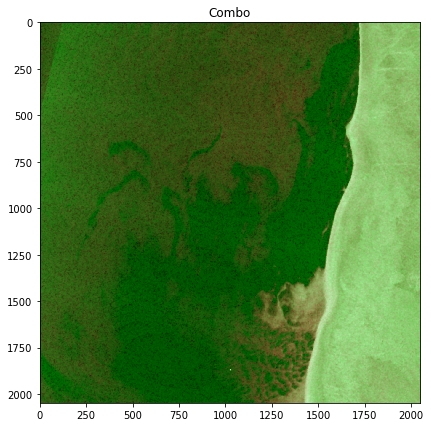

In [15]:
# Пример использования функции и отрисовки HH, HV и Combo кропов

train_names = train_data['file'].values
valid_names = valid_data['file'].values

image = load_combo_image(train_names[-1], CROP_IMG_HH_PATH, CROP_IMG_HV_PATH)

plt.figure(figsize = (25, 7));
plt.imshow(image);
plt.title('Combo');

In [16]:
def get_intervals(data, statistics):
    res = np.zeros((len(statistics), 3, data.shape[0]))
    for i, name in enumerate(data['file'].values):
        image = load_combo_image(name, CROP_IMG_HH_PATH, CROP_IMG_HV_PATH, 4)
        for j, stat in enumerate(statistics):
            res[j, 0, i] = stat[0](image[..., 0])
            res[j, 1, i] = stat[0](image[..., 1])
            res[j, 2, i] = stat[0](image[..., 2])
    for j, stat in enumerate(statistics):
        for c in range(3):
            # точечная оценка
            print('Корреляция ' + stat[1] + ' и метрики для канала ' + str(c) + ':', end=' ')
            print(round(stats.pearsonr(res[j, c,:], data['512_metric'].values)[0], 8))
            
            # интервальная оценка
            print('95% ДИ для корреляции ' + stat[1] + ' и метрики для канала ' + str(c) + ':', end=' ')
            stat_res, metric_res = get_bootstrap_samples(res[j, c,:], data['512_metric'].values, 500, 1000)
            print(stat_intervals(list(map(lambda x: stats.pearsonr(x[0], x[1])[0], list(zip(stat_res, metric_res)))), 0.05))
        print('-' * 120)
    return

In [17]:
# Обертки для функций
def my_skew(data):
    return stats.skew(data, axis=None)

def my_shapiro(data):
    return stats.shapiro(data)[0]

def my_swing(data):
    return data.max() - data.min()

def perc_5_95_swing(data):
    temp = np.percentile(data, [100 * 0.1 / 2., 100 * (1 - 0.1 / 2.)], axis=None)
    return temp.max() - temp.min()
    
def perc_10_90_swing(data):
    temp = np.percentile(data, [100 * 0.2 / 2., 100 * (1 - 0.2 / 2.)], axis=None)
    return temp.max() - temp.min()

def perc_20_80_swing(data):
    temp = np.percentile(data, [100 * 0.4 / 2., 100 * (1 - 0.4 / 2.)], axis=None)
    return temp.max() - temp.min()

In [18]:
statics = [
    (np.median, 'медианы'), 
    (np.mean, 'среднего'), 
    (np.std, 'стандартного отклонения'), 
    (my_skew, 'смещения'),
    (my_shapiro, 'коэффициента нормальности'),
    (my_swing, 'размаха'),
    (perc_5_95_swing, 'размаха 95 и 5 процентелями'),
    (perc_10_90_swing, 'размаха 90 и 10 процентелями'),
    (perc_20_80_swing, 'размаха 80 и 20 процентелями')
]

In [19]:
%%time
np.random.seed(0)
print('На обучающей выборке')
print()
get_intervals(train_data, statics)

На обучающей выборке

Корреляция медианы и метрики для канала 0: 0.17234656
95% ДИ для корреляции медианы и метрики для канала 0: [0.06843904 0.26731118]
Корреляция медианы и метрики для канала 1: 0.36581923
95% ДИ для корреляции медианы и метрики для канала 1: [0.30034874 0.43520608]
Корреляция медианы и метрики для канала 2: 0.28104892
95% ДИ для корреляции медианы и метрики для канала 2: [0.20392059 0.35354301]
------------------------------------------------------------------------------------------------------------------------
Корреляция среднего и метрики для канала 0: 0.15842878
95% ДИ для корреляции среднего и метрики для канала 0: [0.05849588 0.25453431]
Корреляция среднего и метрики для канала 1: 0.33225425
95% ДИ для корреляции среднего и метрики для канала 1: [0.24387855 0.41343709]
Корреляция среднего и метрики для канала 2: 0.2269557
95% ДИ для корреляции среднего и метрики для канала 2: [0.13635065 0.31137712]
------------------------------------------------------------

In [20]:
%%time
np.random.seed(0)
print('На валидационной выборке')
print()
get_intervals(valid_data, statics)

На валидационной выборке

Корреляция медианы и метрики для канала 0: 0.22247261
95% ДИ для корреляции медианы и метрики для канала 0: [0.13901497 0.30102933]
Корреляция медианы и метрики для канала 1: 0.41571729
95% ДИ для корреляции медианы и метрики для канала 1: [0.3516201  0.47970753]
Корреляция медианы и метрики для канала 2: 0.35510906
95% ДИ для корреляции медианы и метрики для канала 2: [0.29484496 0.41322654]
------------------------------------------------------------------------------------------------------------------------
Корреляция среднего и метрики для канала 0: 0.15482029
95% ДИ для корреляции среднего и метрики для канала 0: [0.05677921 0.25222718]
Корреляция среднего и метрики для канала 1: 0.35389749
95% ДИ для корреляции среднего и метрики для канала 1: [0.26705423 0.4382011 ]
Корреляция среднего и метрики для канала 2: 0.20275917
95% ДИ для корреляции среднего и метрики для канала 2: [0.11486547 0.29329777]
-------------------------------------------------------

Из тестов стоит обратить внимание на высокие значения корреляции метрики со значениями среднего, медианы, смещения и W-статистики на 1 канале. Из этого мы можем сделать предположение, что при приближении распределения значений в 1 канале к нормальному увеличивается значение метрики. Надо это доказать.

# Изменения

Прежде всего следует определить способ приведения к нормальному распределению. Попробуем различные варианты и веберем из них лучший

In [21]:
def my_boxcox(data):
    return stats.boxcox(np.reshape(data + 1, -1))[0]

functions = [
    [np.sqrt, 'квадратный корень'],
    [lambda x : x**(1/3), 'корень 3 степени'],
    [lambda x : x**(1/4), 'корень 4 степени'],
    [lambda x : x**(1/5), 'корень 5 степени'],
    [lambda x : x**(1/8), 'корень 8 степени'],
    [lambda x : x**(1/10), 'корень 10 степени'],
    [np.log1p, 'натуральный логарифм'],
    [lambda x : np.log10(x + 1), 'десятичный логарифм'],
    [lambda x : np.log2(x + 1), 'логарифм по основанию 2'],
    [lambda x : 6 - 6/(x+1), 'гиперболическая функция'],
    [lambda x : 6*((1 / (1 + np.exp(-x / 16))) - 1/2) * 2, 'сигмоида'],
    [lambda x : 6*(np.exp(2*x / 16) - 1) / (np.exp(2*x / 16) + 1), 'гиперболический тангенс'],
    [my_boxcox, 'преобразование Бокса-Кокса']
]

statics = [
    (np.median, 'медиана'), 
    (np.mean, 'среднее арифметическое'), 
    (my_skew, 'смещение'),
    (my_shapiro, 'коэффициент нормальности')
]

In [22]:
def load_normal_image(image_name, image_folder, funcs, stats, scale_factor = 1):
    image = load_image(image_name, image_folder).astype(np.float32)[..., 0]
    temp = np.zeros((len(funcs) + 1, len(stats)))
    
    if scale_factor > 1:
        shape = (image.shape[1] // scale_factor, image.shape[0] // scale_factor)
        image = cv2.resize(image, shape).astype(np.float32)
    
    for j, stat in enumerate(stats):
        temp[0, j] = stat[0](image / 255)
        for i, func in enumerate(funcs):
            if func[0] == my_boxcox:
                f = func[0](image)
                mi = f.min()
                ma = f.max()
                f = (f - mi) / (ma - mi)
                temp[i+1, j] = stat[0](f)
            else:
                temp[i+1, j] = stat[0](func[0](image) / func[0](255))
    
    return temp

In [23]:
def get_normal_intervals(data, funcs, stats):
    df = pd.DataFrame(index = ['функция', 'статистика', 'Л.И', 'П.И'], columns=np.arange(0, len(funcs) * len(stats)))
    res = np.zeros((len(funcs) + 1, len(stats), data.shape[0]))
    for j, name in enumerate(data['file'].values):
        res[:, :, j] = load_normal_image(name, CROP_IMG_HV_PATH, funcs, stats, 4)
            
    count = 0
    for i, func in enumerate(funcs):
        for j, stat in enumerate(stats):
            default_scores, transformed_scores = get_bootstrap_samples(res[0, j, :], res[i+1, j, :], 500, 1000)
            default_scores = list(map(np.median, default_scores))
            transformed_scores = list(map(np.median, transformed_scores))
            delta_scores = list(map(lambda x: x[1] - x[0], zip(default_scores, transformed_scores)))
            interval = stat_intervals(delta_scores, 0.05)
            df[count] = [func[1], stat[1], interval[0], interval[1]]
            count += 1
        
    return df.T

In [24]:
%%time
np.random.seed(0)
result = get_normal_intervals(train_data, functions, statics)

CPU times: user 1h 25min 27s, sys: 1min 37s, total: 1h 27min 5s
Wall time: 1h 25min 34s


In [25]:
print('Обучающая выборка')
result

Обучающая выборка


,функция,статистика,Л.И,П.И
0,квадратный корень,медиана,0.213282,0.224898
1,квадратный корень,среднее арифметическое,0.156276,0.1793
2,квадратный корень,смещение,-0.610045,-0.428035
3,квадратный корень,коэффициент нормальности,0.0956469,0.116381
4,корень 3 степени,медиана,0.361349,0.372346
5,корень 3 степени,среднее арифметическое,0.270976,0.299271
6,корень 3 степени,смещение,-0.87731,-0.676643
7,корень 3 степени,коэффициент нормальности,0.137185,0.162129
8,корень 4 степени,медиана,0.460444,0.467894
9,корень 4 степени,среднее арифметическое,0.348796,0.377686


In [26]:
%%time
np.random.seed(0)
result = get_normal_intervals(valid_data, functions, statics)

CPU times: user 16min 36s, sys: 19.3 s, total: 16min 55s
Wall time: 16min 38s


In [27]:
print('Валидационная выборка')
result

Валидационная выборка


,функция,статистика,Л.И,П.И
0,квадратный корень,медиана,0.217073,0.230517
1,квадратный корень,среднее арифметическое,0.162603,0.185243
2,квадратный корень,смещение,-0.761038,-0.54799
3,квадратный корень,коэффициент нормальности,0.113743,0.136539
4,корень 3 степени,медиана,0.36469,0.376403
5,корень 3 степени,среднее арифметическое,0.275502,0.301395
6,корень 3 степени,смещение,-1.10231,-0.850906
7,корень 3 степени,коэффициент нормальности,0.155031,0.182402
8,корень 4 степени,медиана,0.462734,0.470523
9,корень 4 степени,среднее арифметическое,0.352322,0.378956


Из разных способов преобразования больше всех выделяется преобразование Бокса-Кокса, так как оно дает наибольшую разницу по коэффициенту нормальности и по остальным статистикам имеет высокие показатели, которые сравнимы с изначальным преобразованием с помощью натурального логарифма.

Поэтому сравним метрики после преобразования Бокса-Кокса. Для полноты вернемся к рассмотрению и на разных размерах изображений.

# Сравнение метрик

In [28]:
t = pd.read_csv('df_miou_train_crops_exp_8_12.csv', sep=',', names=['files', 'old_512', 'old_2048', 'new_512', 'new_2048'], header=0)
v = pd.read_csv('df_miou_valid_crops_exp_8_12.csv', sep=',', names=['files', 'old_512', 'old_2048', 'new_512', 'new_2048'], header=0)

In [29]:
def get_bootstrap_samples(data_1, data_2, size, n_samples):
    indices = np.random.randint(0, len(data_1), (n_samples, size))
    samples_1 = data_1[indices]
    samples_2 = data_2[indices]
    return samples_1, samples_2
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [30]:
np.random.seed(0)

print('Доверительные интервалы для медианы от метрики на обучающей выборке')
print()

old_512_metric_scores, new_512_metric_scores = get_bootstrap_samples(t['old_512'].values, 
                                                                            t['new_512'].values, 
                                                                            100, 1000)

old_2048_metric_scores, new_2048_metric_scores = get_bootstrap_samples(t['old_2048'].values, 
                                                                            t['new_2048'].values, 
                                                                            100, 1000)

median_old_512_metric_scores = list(map(np.median, old_512_metric_scores))
median_new_512_metric_scores = list(map(np.median, new_512_metric_scores))

median_old_2048_metric_scores = list(map(np.median, old_2048_metric_scores))
median_new_2048_metric_scores = list(map(np.median, new_2048_metric_scores))

print("95% ДИ на изображении 512р до преобразования:",  
      stat_intervals(median_old_512_metric_scores, 0.05))
print("95% ДИ на изображении 512р после преобразования:",  
      stat_intervals(median_new_512_metric_scores, 0.05))
print("95% ДИ на изображении 2048р до преобразования",  
      stat_intervals(median_old_2048_metric_scores, 0.05))
print("95% ДИ на изображении 2048р после преобразования",  
      stat_intervals(median_new_2048_metric_scores, 0.05))

print('-'*120)

delta_512_scores = list(map(lambda x: x[1] - x[0], zip(median_old_512_metric_scores, median_new_512_metric_scores)))
delta_2048_scores = list(map(lambda x: x[1] - x[0], zip(median_old_2048_metric_scores, median_new_2048_metric_scores)))

print("95% ДИ для разности между старыми и новыми изображениями 512р",  stat_intervals(delta_512_scores, 0.05))
print("95% ДИ для разности между старыми и новыми изображениями 2048р",  stat_intervals(delta_2048_scores, 0.05))

Доверительные интервалы для медианы от метрики на обучающей выборке

95% ДИ на изображении 512р до преобразования: [0.91613409 0.95304826]
95% ДИ на изображении 512р после преобразования: [0.91562001 0.95212939]
95% ДИ на изображении 2048р до преобразования [0.91603031 0.95437295]
95% ДИ на изображении 2048р после преобразования [0.91272785 0.95081835]
------------------------------------------------------------------------------------------------------------------------
95% ДИ для разности между старыми и новыми изображениями 512р [-0.01333863  0.00889002]
95% ДИ для разности между старыми и новыми изображениями 2048р [-0.01563479  0.00642799]


In [31]:
np.random.seed(0)

print('Доверительные интервалы для медианы от метрики на валидационной выборке')
print()

old_512_metric_scores, new_512_metric_scores = get_bootstrap_samples(v['old_512'].values, 
                                                                            v['new_512'].values, 
                                                                            100, 1000)

old_2048_metric_scores, new_2048_metric_scores = get_bootstrap_samples(v['old_2048'].values, 
                                                                            v['new_2048'].values, 
                                                                            100, 1000)

median_old_512_metric_scores = list(map(np.median, old_512_metric_scores))
median_new_512_metric_scores = list(map(np.median, new_512_metric_scores))

median_old_2048_metric_scores = list(map(np.median, old_2048_metric_scores))
median_new_2048_metric_scores = list(map(np.median, new_2048_metric_scores))

print("95% ДИ на изображении 512р до преобразования:",  
      stat_intervals(median_old_512_metric_scores, 0.05))
print("95% ДИ на изображении 512р после преобразования:",  
      stat_intervals(median_new_512_metric_scores, 0.05))
print("95% ДИ на изображении 2048р до преобразования",  
      stat_intervals(median_old_2048_metric_scores, 0.05))
print("95% ДИ на изображении 2048р после преобразования",  
      stat_intervals(median_new_2048_metric_scores, 0.05))

print('-'*120)

delta_512_scores = list(map(lambda x: x[1] - x[0], zip(median_old_512_metric_scores, median_new_512_metric_scores)))
delta_2048_scores = list(map(lambda x: x[1] - x[0], zip(median_old_2048_metric_scores, median_new_2048_metric_scores)))

print("95% ДИ для разности между старыми и новыми изображениями 512р",  stat_intervals(delta_512_scores, 0.05))
print("95% ДИ для разности между старыми и новыми изображениями 2048р",  stat_intervals(delta_2048_scores, 0.05))

Доверительные интервалы для медианы от метрики на валидационной выборке

95% ДИ на изображении 512р до преобразования: [0.88569498 0.92958873]
95% ДИ на изображении 512р после преобразования: [0.8842808 0.9249496]
95% ДИ на изображении 2048р до преобразования [0.8874885  0.93009232]
95% ДИ на изображении 2048р после преобразования [0.88032848 0.92270329]
------------------------------------------------------------------------------------------------------------------------
95% ДИ для разности между старыми и новыми изображениями 512р [-0.01791275  0.00894038]
95% ДИ для разности между старыми и новыми изображениями 2048р [-0.02415816  0.00289193]


Исходя из границ доверительных интервалов мы не можем опровергнуть гипотезу о том, что статистической разницы нет, однако стоит заметить небольшой перекос в отрицательную сторону. Нарисуем графики для визульного анализа

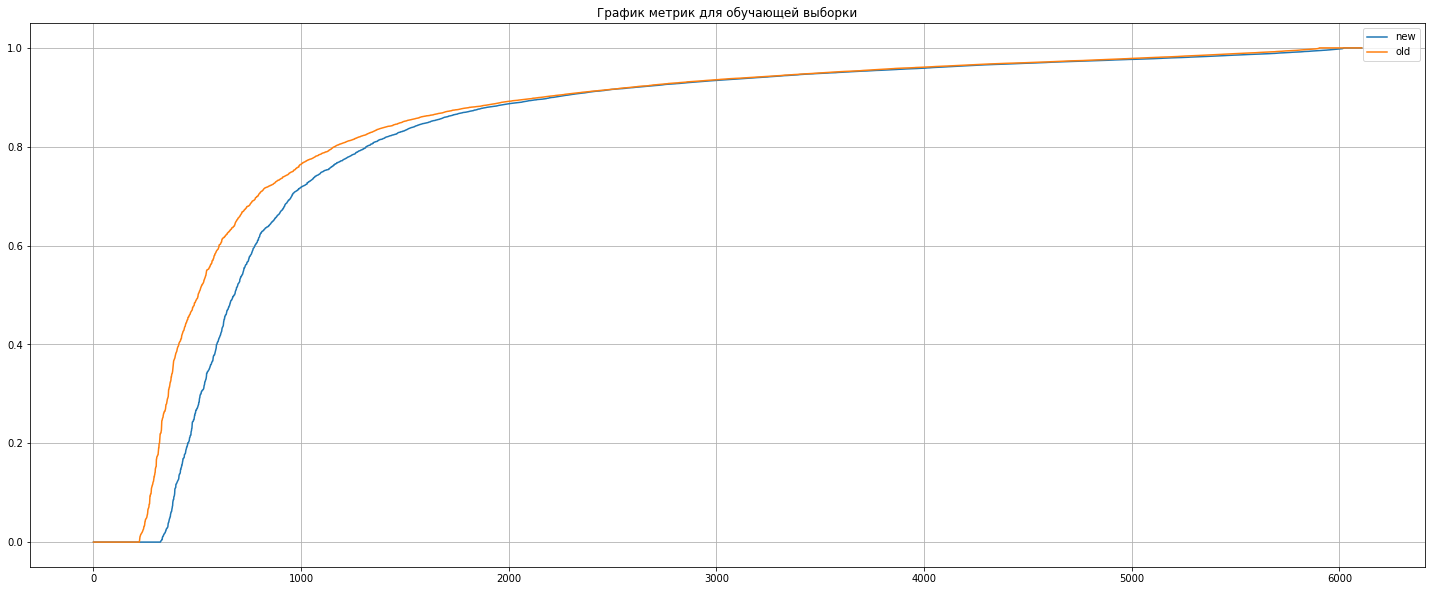

In [32]:
_, axes = plt.subplots(1, 1, figsize = (25, 10));
axes.grid();
axes.plot(t['new_512'].sort_values().values, label = 'new');
axes.plot(t['old_512'].sort_values().values, label = 'old');
plt.legend();
plt.title('График метрик для обучающей выборки');

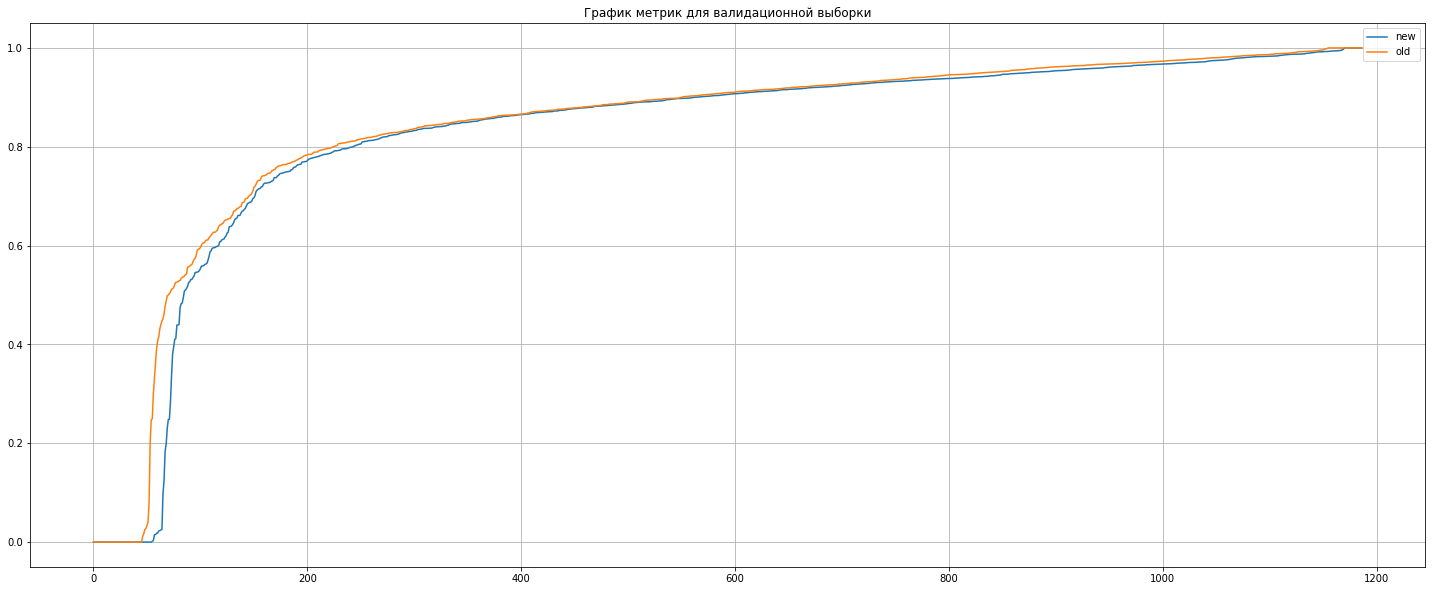

In [33]:
_, axes = plt.subplots(1, 1, figsize = (25, 10));
axes.grid();
axes.plot(v['new_512'].sort_values().values, label = 'new');
axes.plot(v['old_512'].sort_values().values, label = 'old');
plt.legend();
plt.title('График метрик для валидационной выборки');

К сожалению, из визуального анализа мы можем сказать, что метрики после преобразования Бокса-Кокса НЕ лучше чем изначальные. Таким образом нельзя утверждать, что предложенный способ преобразований значимо улучшил метрику. Однако в рамках данной задачи окончательное решение по качеству изображений для модели принималось экспертом-геологом. Он подтвердил, что после преобразования Бокса-Кокса изображения стали лучше визуально, что важно для их ручной сегментации. Так же он отметил улучшение качества результата автоматической сегментации снимков с помощью модели, обученной на преобразованных данных.
 
В итоге получилась ситуация, когда статистически нет разницы, но с точки зрения эксперта-геолога она имеется. Причина несогласованности оценок - невозможность полной формализации оценки качества и как следствие не полное соответствие анализируемой метрики реальному изменению результата. Тем не менее даже в таких условиях удалось выбрать преобразование, которое улучшило результат и позволило избежать серии длительных экспериментов.